In [34]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np

########################################################################
# 策略继承CtaTemplate
class Bolling(CtaTemplate):
    className = 'bolling'
    author = 'fengxiu'
    
    # 策略参数
    lowVolThrehold = 0.005; highVolThrehold = 1.5
    BBandPeriod = 20
    stopRatio = 0.04
    fastPeriod = 20; slowPeriod = 40
    nPos = 0
    fixsize = 100
    Ratio = 0.02
    proportion = 2
    sizeRatio = 0.3
    
    # 策略变量
    transactionPrice = {}      # 记录成交价格
    up ={}
    mid = {}
    low = {}
    sigma = {}
    maTrend = {} # 记录趋势状态，多头1，空头-1
    
    # 参数列表，保存了参数的名称
    paramList = ['lowVolThrehold',
                 'highVolThrehold',
                 'BBandPeriod',
                 'stopRatio'
                 'fastPeriod',
                 'slowPeriod',
                ]    
    
    # 变量列表，保存了变量的名称
    varList = ['transactionPrice'
               'up',
               'mid',
               'low',
               'sigma',
               'maTrend'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.setArrayManagerSize(100)
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        transactionPrice = {s:0 for s in self.symbolList}      # 记录成交价格
        self.upper = {s:0 for s in self.symbolList} 
        self.middle = {s:0 for s in self.symbolList}
        self.lower = {s:0 for s in self.symbolList} 
        self.signal = {s:0 for s in self.symbolList}
        self.maTrend = {s:0 for s in self.symbolList} 
               
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
     #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
        symbol = bar.vtSymbol
        lastOrder=self.transactionPrice[symbol]
        # 固定损失加仓
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 3):    # 持有多头仓位并且加仓次数不超过3次
            if self.nPos >= 1: # 上一次的加仓亏损达到原来盈利比例的 1/proportion 倍
                if lastOrder/bar.close-1 >= self.Ratio/self.proportion: 
                    self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                    self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                elif bar.close/lastOrder-1>= self.Ratio/self.proportion:
                    self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
            if bar.close/lastOrder-1>= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数增加 1 次
                add_fixsize = self.fixsize*self.proportion - self.fixsize
                self.buy(symbol,bar.close*1.02, add_fixsize)  # 加仓数量为
                self.short(symbol,bar.close*0.98, add_fixsize/2)
                self.fixsize = add_fixsize + self.fixsize
                
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 3):    # 持有空头仓位并且加仓次数不超过3次
            if self.nPos >= 1: # 上一次的加仓亏损达到原来盈利比例的 1/proportion 倍
                if bar.close/lastOrder-1>= self.Ratio/self.proportion:
                    self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                    self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                elif lastOrder/bar.close-1 >= self.Ratio/self.proportion: 
                    self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
            if lastOrder/bar.close-1 >= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                add_fixsize = self.fixsize*self.proportion - self.fixsize
                self.short(symbol,bar.close*0.98,self.fixsize)  # 目标仓位100手，分别加仓25手、20手、15手，10手
                self.buy(symbol,bar.close*1.02, add_fixsize)
                self.fixsize = add_fixsize + self.fixsize
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------  
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
                
        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return

        # 指标计算
        up, mid, low = ta.BBANDS(am60.close, self.BBandPeriod)
        sigma = (up -  mid) / (2 *  mid)
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        #定义事件信号
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1

        # 现象条件
        breakUp = (am60.close[-2] <= up[-2]) and (am60.close[-1] > up[-1])
        breakDn = (am60.close[-2] <= low[-2]) and (am60.close[-1] > low[-1])
        
        # 进出场条件
        if breakUp and (self.maTrend[symbol]==1)and (sigma[-1] < self.lowVolThrehold) and (self.posDict[symbol + "_LONG"]==0):
            if self.posDict[symbol + "_SHORT"] == 0:
                self.buy(symbol, bar.close * 1.01, self.fixsize*self.sizeRatio)
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.01, self.posDict[symbol + "_SHORT"])
                self.buy(symbol, bar.close * 1.01, self.fixsize*self.sizeRatio)

        elif breakDn and (self.maTrend[symbol]==-1) and (sigma[-1] < self.lowVolThrehold) and (self.posDict[symbol + "_SHORT"]==0):
            if self.posDict[symbol + "_LONG"] == 0:
                 self.short(symbol, bar.close * 0.99, self.fixsize*self.sizeRatio)
            elif self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
                self.short(symbol, bar.close *0.99, self.fixsize*self.sizeRatio)

        if sigma[-1]>self.highVolThrehold and (self.maTrend[symbol]==-1):
            if self.posDict[symbol + "_LONG"] > 0 and (sigma[-1] > 2*self.lowVolThrehold):
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.01, self.posDict[symbol + "_SHORT"])
                self.putEvent()
   
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        self.transactionPrice[symbol] = trade.price # 记录成交价格          
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function Bolling.on60MinBar at 0x000001BC8DA492F0>, <__main__.Bolling object at 0x000001BC82D3D1D0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function Bolling.onBar at 0x000001BC8DA49268>, <__main__.Bolling object at 0x000001BC82D3D1D0>)
2018-12-18 20:56:39.886423	开始回测
2018-12-18 20:56:39.886423	策略初始化
2018-12-18 20:56:39.886423	载入历史数据。数据范围:[20180606 10:00,20180608 12:00)
2018-12-18 20:56:40.485797	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-18 20:56:40.488762	载入完成，数据量：3000
2018-12-18 20:56:40.489790	策略初始化完成
2018-12-18 20:56:40.489790	策略启动完成
2018-12-18 20:56:40.489790	开始回放回测数据,回测范围:[20180608 12:00,20181210 12:00)
2018-12-18 20:56:40.517713	载入历史数据。数据范围:[20180608 12:00,20181210 12:00)


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

2018-12-18 20:57:02.926766	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-18 20:57:03.000569	载入完成，数据量：264608
2018-12-18 20:57:03.040466	当前回放数据:[20180608 12:00,20181210 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180608120000
2018-12-18 20:57:03.042427	载入历史数据。数据范围:[20180607 20:51,20180610 12:01)


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

2018-12-18 20:57:03.659809	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-18 20:57:03.662796	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180608102100 , 20180608120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180608120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180608120000
2018-12-18 20:57:03.691757	载入历史数据。数据范围:[20180501 15:00,20180607 20:50)


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

2018-12-18 20:57:07.769780	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-18 20:57:07.785768	载入完成，数据量：53630
2018-12-18 20:57:07.803690	载入历史数据。数据范围:[20180610 12:01,20180610 13:00)
2018-12-18 20:57:07.822640	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-18 20:57:07.822640	！！ 数据量为 0 ！！


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 293, in loadHistoryData
    file_data.to_hdf(file_path, key="d")
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 1993, in to_hdf
    return pytables.to_hdf(path_or_buf, key, self, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 278, in to_hdf
    complib=complib) as store:
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 491, in __init__
    self.open(mode=mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\pytables.py", line 604, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tables\file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "C:\ProgramData\Anacon

[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180604080000 , 20180608110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180608120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180608120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7630.49, 'high': 7645.0, 'low': 7596.0, 'close': 7625.17, 'date': '20180608', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 8, 12, 0), 'volume': 1634.2577280000005, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180604090000 , 20180608120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180608120000
2018-12-18 20:57:27.679521	数据回放结束ss: 100%    
2018-12-18 20:57:27.680518	计算按日统计结果
2018-12-18 20:57:27.718445	------------------------------
2018-12-18 20:57:27.719441	首个交易日：	2018-06-08 00:00:00
2018-12-18 20:57:27.719441	最后交易日：	2018-12-10 00:00:00
2018-12-18 20:57:27.719441	总交易日：	186
2018-12-18 20:57:27.719441	盈利交易日	37
2018-12-18 20:57:27.

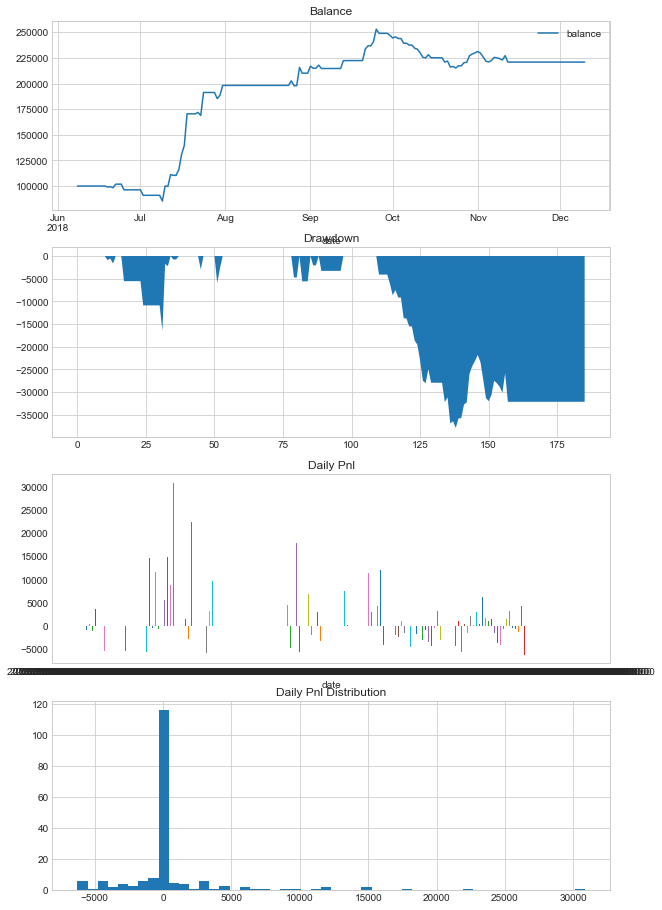

2018-12-18 20:57:32.094709	计算回测结果
2018-12-18 20:57:32.106677	------------------------------
2018-12-18 20:57:32.106677	第一笔交易：	2018-06-22 11:00:00
2018-12-18 20:57:32.107674	最后一笔交易：	2018-12-10 11:58:00
2018-12-18 20:57:32.107674	总交易次数：	133
2018-12-18 20:57:32.107674	总盈亏：	120,907.74
2018-12-18 20:57:32.107674	最大回撤: 	-32,821.65
2018-12-18 20:57:32.107674	平均每笔盈利：	909.08
2018-12-18 20:57:32.107674	平均每笔滑点：	0.07
2018-12-18 20:57:32.107674	平均每笔佣金：	119.14
2018-12-18 20:57:32.107674	胜率		80.45%
2018-12-18 20:57:32.107674	盈利交易平均值	1,876.09
2018-12-18 20:57:32.107674	亏损交易平均值	-3,070.52
2018-12-18 20:57:32.107674	盈亏比：	0.61


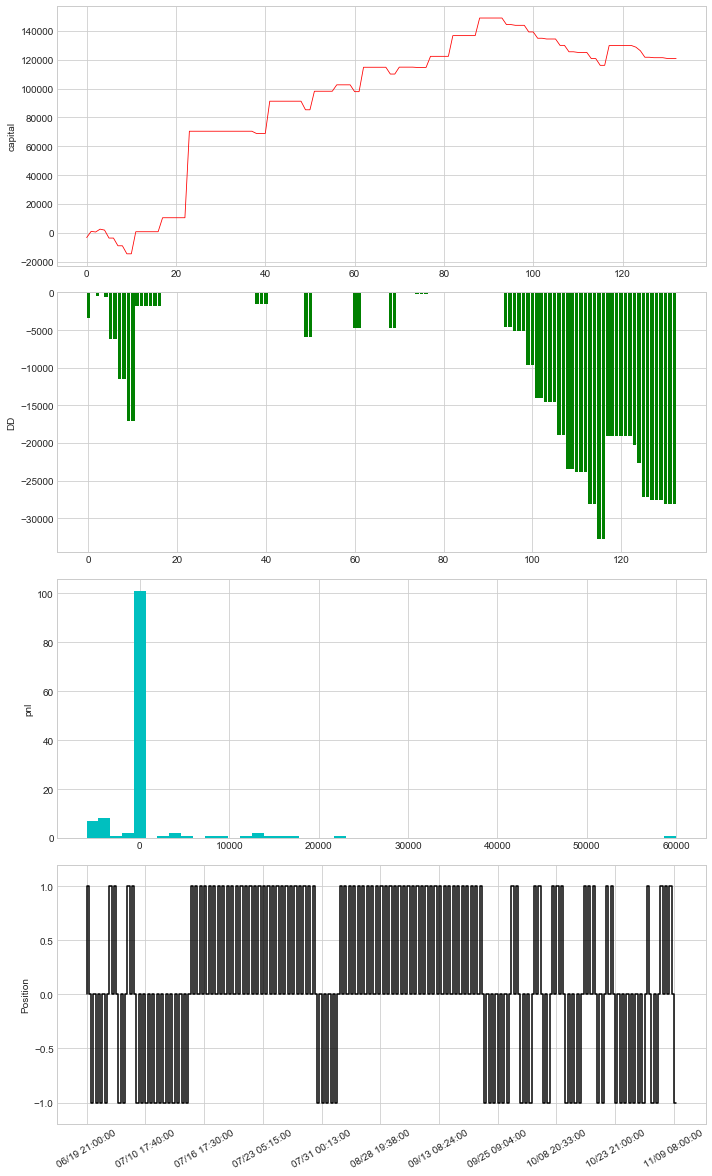

2018-12-18 20:57:33.091045	计算按日统计结果


(               netPnl  slippage  commission   turnover  tradeCount  \
 date                                                                 
 2018-06-08     0.0000      0.00      0.0000        0.0           0   
 2018-06-09     0.0000      0.00      0.0000        0.0           0   
 2018-06-10     0.0000      0.00      0.0000        0.0           0   
 2018-06-11     0.0000      0.00      0.0000        0.0           0   
 2018-06-12     0.0000      0.00      0.0000        0.0           0   
 2018-06-13     0.0000      0.00      0.0000        0.0           0   
 2018-06-14     0.0000      0.00      0.0000        0.0           0   
 2018-06-15     0.0000      0.00      0.0000        0.0           0   
 2018-06-16     0.0000      0.00      0.0000        0.0           0   
 2018-06-17     0.0000      0.00      0.0000        0.0           0   
 2018-06-18     0.0000      0.00      0.0000        0.0           0   
 2018-06-19  -904.9473      0.06    101.4873   202974.6           1   
 2018-

In [35]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=50)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf
parameterDict = {'symbolList':['BTCUSDT:binance']}
runBacktesting(Bolling, parameterDict, '20180608 12:00', '20181210 12:00', 0.002, 5/10000)

In [ ]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('fastPeriod', 5, 40, 5)    
setting.addParameter('slowPeriod', 40, 80, 10)    
setting.addParameter('lowVolThrehold', 0.003, 0.005, 0.001)    
setting.addParameter('highVolThrehold', 0.5, 2, 0.3)
setting.addParameter('fixsize = 100', 20, 140, 10)
setting.addParameter('sizeRatio', 0.1, 0.5, 5)
setting.addParameter('Ratio', 0.02, 0.04, 0.01)
setting.addParameter('sizeRatio', 0.1, 0.5, 5)
setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MultiFrameMaStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

In [ ]:
import pandas as pd

print(pd.DataFrame(resultList).sort_values(1,  ascending=False))

In [ ]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))